# Exercise 9-1 & 10-1

### DSC530
#### Taniya Adhikari
##### 11/01/2020

In [122]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot
import scipy

## Exercise 9-1

## Hypothesis testing

In [76]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

**Exercise:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

## Permutation test

To compute the p-value of an observed difference in means, we can assume that there is no difference between the groups and generate simulated results by shuffling the data.

In [77]:
class DiffMeansPermute(thinkstats2.HypothesisTest):
    
    # calculates the absolute difference in mean for both groups
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat
    
    # combines the two groups into one
    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    # simulates the null hypothesis
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

## Difference in standard deviation

In this framework, it is easy to use other test statistics.  For example, if we think the variance for first babies might be higher, we can run this test:

In [78]:
class DiffStdPermute(DiffMeansPermute):

    # calculates difference in standard deviation
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

## Testing correlation

To check whether an observed correlation is statistically significant, we can run a permutation test with a different test statistic.

In [79]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    # calculates correlation
    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    # simulates the null hypothesis
    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

## Chi-square test of pregnancy length

In [80]:
class PregLengthTest(thinkstats2.HypothesisTest):

    # pools the two group
    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    # simulates the null hypothesis
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    # computes ChiSquared statistics
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    # computes observed frequencies and expected frequencies. Also creates Histogram.
    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

### Answer 9-1

In [81]:
def tests(live, iters=1000):

    n = len(live)
    firsts = live[live.birthord == 1]  # creates first group
    others = live[live.birthord != 1]  # creates others group
    print("The sample size is {}".format(n))
    
    # Test 1: compare mean pregnancy lengths
    # H_0: There is no difference between the mean pregnancy length between the first babies and others
    # H_1: There is a difference in means.    
    data1 = firsts.prglngth.values, others.prglngth.values
    dt1 = DiffMeansPermute(data1)
    pvalue1 = dt1.PValue(iters=iters)
    print("Test 1: Difference in mean of pregnancy lengths for firsts and others. The p-value is {}".format(pvalue1))
    
    # Test 2: compare variance pregnancy lengths
    # H_0: There is no difference between the variance pregnancy length between the first babies and others
    # H_1: There is a difference in variance.    
    dt2 = DiffStdPermute(data1)
    pvalue2 = dt2.PValue()
    print("Test 2: Difference in variance of pregnancy lengths for firsts and others. The p-value is {}".format(pvalue2))

    # Test 3: Testing Correlation
    # H_0: There is no correlation between mother's age and birth weight
    # H_1: There is a correlation
    cleaned = live.dropna(subset=['agepreg', 'totalwgt_lb'])  # drops any missing values
    data2 = cleaned.agepreg.values, cleaned.totalwgt_lb.values
    dt3 = CorrelationPermute(data2)
    pvalue3 = dt3.PValue(iters=iters)
    print("Test 3: Correlation between mother's age and birth weight. The p-value is {}".format(pvalue3))
    
    
    # Test 4: Testing Proportions - Chi-Squared
    # H_0: There is no difference in observed and expected frequencies for each value
    # H_1: There is a difference
    data1 = firsts.prglngth.values, others.prglngth.values
    dt4 = PregLengthTest(data1)
    pvalue4 = dt4.PValue(iters=iters)
    print("Test 4: Chi-Squared Test. The p-value is {}\n".format(pvalue4))
    
    

In [82]:
import first

live, firsts, others = first.MakeFrames()
n = len(live)

# creates 5 different random subset of NSFG data
for _ in range(8):
    sample = thinkstats2.SampleRows(live, n)
    tests(sample)
    n //= 2

The sample size is 9148
Test 1: Difference in mean of pregnancy lengths for firsts and others. The p-value is 0.184
Test 2: Difference in variance of pregnancy lengths for firsts and others. The p-value is 0.089
Test 3: Correlation between mother's age and birth weight. The p-value is 0.0
Test 4: Chi-Squared Test. The p-value is 0.0

The sample size is 4574
Test 1: Difference in mean of pregnancy lengths for firsts and others. The p-value is 0.547
Test 2: Difference in variance of pregnancy lengths for firsts and others. The p-value is 0.102
Test 3: Correlation between mother's age and birth weight. The p-value is 0.0
Test 4: Chi-Squared Test. The p-value is 0.0

The sample size is 2287
Test 1: Difference in mean of pregnancy lengths for firsts and others. The p-value is 0.587
Test 2: Difference in variance of pregnancy lengths for firsts and others. The p-value is 0.098
Test 3: Correlation between mother's age and birth weight. The p-value is 0.002
Test 4: Chi-Squared Test. The p-valu

**As the sample size started decreasing the p-value started increasing in most tests. However, it didn't do the same for all tests and gave random p-value. There are some p-values that are small even with smaller sample size. For example
n = 571 and correlation p-value = 0.012, or n = 142 and correlation p-value = 0.014**



## Exercise 10-1

**Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

The following function computes the intercept and slope of the least squares fit.

In [128]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

# calculates slope and intercepttof the relationship
def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    # calculates covariance of x & y and then divide it by x variance.
    # slope of the linear fit
    slope = Cov(xs, ys, meanx, meany) / varx
    
    # intercept of the linear fit
    inter = meany - slope * meanx

    return inter, slope


# function for fitted line.
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys


# returns the difference between actual values and fitted lines
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)   # observed values
    yhat = inter + slope * xs   # expected values
    res = ys - yhat
    return res

# r-squared
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

In [92]:
import brfss

data = brfss.ReadBrfss(nrows=None)
data = data.dropna(subset=['htm3', 'wtkg2'])   # drops missing values
data

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0
5,42.0,1,118.181818,415.161314,109.09,183.0
...,...,...,...,...,...,...
414504,23.0,1,84.090909,43.439320,88.64,191.0
414505,49.0,2,70.454545,6.216538,72.73,170.0
414506,45.0,1,86.363636,20.617560,90.91,178.0
414507,52.0,2,89.090909,11.188138,89.09,157.0


In [93]:
data['log_wtkg2'] = np.log10(data.wtkg2)   # log weights
data

,age,sex,wtyrago,finalwt,wtkg2,htm3,log_wtkg2
0,82.0,2,76.363636,185.870345,70.91,157.0,1.850707
1,65.0,2,72.727273,126.603027,72.73,163.0,1.861714
3,61.0,1,73.636364,517.926275,73.64,170.0,1.867114
4,26.0,1,88.636364,1252.624630,88.64,185.0,1.947630
5,42.0,1,118.181818,415.161314,109.09,183.0,2.037785
...,...,...,...,...,...,...,...
414504,23.0,1,84.090909,43.439320,88.64,191.0,1.947630
414505,49.0,2,70.454545,6.216538,72.73,170.0,1.861714
414506,45.0,1,86.363636,20.617560,90.91,178.0,1.958612
414507,52.0,2,89.090909,11.188138,89.09,157.0,1.949829


In [106]:
# least squares for height vs log10 of weights
intercept, slope = LeastSquares(data.htm3, data.log_wtkg2)
intercept, slope

(0.9930804163917814, 0.005281454169417991)

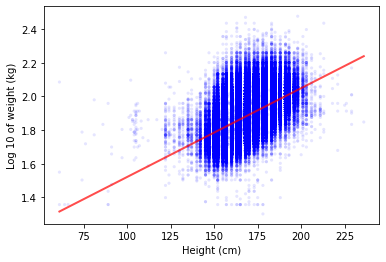

In [107]:
# Scatter plot
fit_xs, fit_ys = FitLine(data.htm3, intercept, slope)  #fit line

thinkplot.Scatter(data.htm3, data.log_wtkg2, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Height (cm)",
                 ylabel='Log 10 of weight (kg)',
                 legend=False)

**Scatter plot with Log transformation of weights**

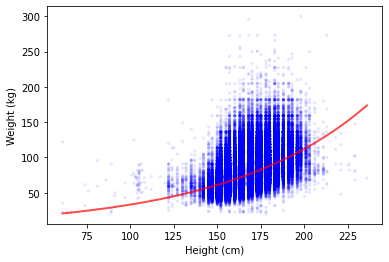

In [108]:
# Scatter plot
fit_xs, fit_ys = FitLine(data.htm3, intercept, slope)  #fit line

thinkplot.Scatter(data.htm3, data.wtkg2, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, 10**fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Height (cm)",
                 ylabel='Weight (kg)',
                 legend=False)

**Scatter plot with Inverse transformation of weights**

Plot the percentiles of the residuals versus the average hieght in each group.

In [114]:
residuals = Residuals(data.htm3, data.log_wtkg2, intercept, slope)
data['residual'] = residuals

# array of bins from 130 to 210 with increments of 5
bins = np.arange(130, 210, 5)

# index of the bin
indices = np.digitize(data.htm3, bins)

# grouping them by indices
groups = data.groupby(indices)

In [113]:
for i, group in groups:
    print(i, len(group))

0 210
1 95
2 228
3 477
4 2162
5 18759
6 45761
7 70610
8 72138
9 61725
10 49938
11 43555
12 20077
13 7784
14 1777
15 405
16 131


In [119]:
# caluclating mean and cdf for each group using thinkstats2.
height_mean = [group.htm3.mean() for i, group in groups][1:-1]
residual_cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

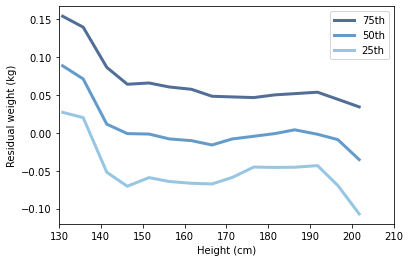

In [120]:
# plotting percentiles
thinkplot.PrePlot(3)
# calculating percentile for each group
for percent in [75, 50, 25]:
    y = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(height_mean, y, label=label)
    
thinkplot.Config(xlabel='Height (cm)', 
                 ylabel='Residual weight (kg)', 
                 xlim=[130, 210], legend=True)

The median seems nearly zero, so if we know the height in cm then we can guess the weight about 50% of the time.
All lines looks parallel showing that the variance of the residuals are same for all. But lines have some curvature, showing that the relationship is non-linear.

In [134]:
# Pearson Correlation
corr, _ = scipy.stats.pearsonr(data.htm3, data.log_wtkg2)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons p^2: %.3f' % corr**2)
# Compute coefficient of determination.

r2 = CoefDetermination(data.log_wtkg2, residuals)
print('r^2: %.3f' % r2)

Pearsons correlation: 0.532
Pearsons p^2: 0.283
r^2: 0.283


In [131]:
corr**2 - r2

6.161737786669619e-15

$R^2 = \rho^2$.

RMSE also Standard deviation of residuals shows the goodness of fit.

In [139]:
# RMSE without the heights
std_ys = thinkstats2.Std(data.log_wtkg2)
print('RMSE without the use of Heights: %.3f' % std_ys)

RMSE without the use of Heights: 0.103


In [140]:
# RMSE with the heights
std_res = thinkstats2.Std(residuals)
print('RMSE with the height: %.3f' % std_res)

RMSE with the height: 0.087


In [142]:
1 - std_res / std_ys

0.1530849765879294

If we use height to guess the log of weight, the RMSE is 0.087. But if don't use height than RMSE is 0.103. There is only 15.3 % difference between the two.

In [152]:
# creates a random subset sample from the dataframe. 
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    
    return SampleRows(df, len(df), replace=True)


# resampling with weights
def ResampleRowsWeighted(df, column):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

def Summarize(estimates, actual=None):
    mean = Mean(estimates)  # calculates mean
    stderr = Std(estimates, mu=actual)   # calculates Std
    cdf = thinkstats2.Cdf(estimates)   # creates a distribution
    ci = cdf.ConfidenceInterval(90)    # calculates confidence interval
    print('mean, SE, CI', mean, stderr, ci)

In [153]:
# unweighted
unweighted_df = ResampleRows(data)   # calls the ResampleRows function
mean_unweighted = unweighted_df.htm3.mean()
estimates_unweighted = [mean_unweighted for _ in range(100)]
Summarize(estimates_unweighted)

mean, SE, CI 168.9726980132986 2.842170943040401e-14 (168.97269801329858, 168.97269801329858)


In [154]:
# weighted
weighted_df = ResampleRowsWeighted(data, 'finalwt')    # calls ResampleRowsWeighted with weight column "finalwt"
mean_weighted = weighted_df.htm3.mean()
estimates_weighted = [mean_weighted for _ in range(100)]
Summarize(estimates_weighted)

mean, SE, CI 170.5113861436164 8.526512829121202e-14 (170.51138614361648, 170.51138614361648)


**The difference in estimates means with and without weighting is 1.538 cm. The difference is much larger than a sampling error 5.684341886080802e-14 which means the difference is not due to chance.**